In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 729.00 KiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


# Feature generation

In [0]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
from emotenn import constants as ct, gen_utils as gu, load_utils as lu

In [0]:
for archive in [ct.RAVDESS_SPEECH, ct.RAVDESS_SONG]:
    lu.download_file_from_google_drive(archive, exist_ok=True)
    gu.unpack(archive.path)

In [0]:
sound_files_pattern = os.path.join(ct.UNPACKED_DIR, 'Audio_*_Actors_01-24', '**', '*.wav')
sound_files = glob.glob(sound_files_pattern, recursive=True)

In [0]:
labels = []
for sound_path in sound_files:
    name = os.path.basename(sound_path)
    emotion = name[6:8]
    if emotion in ['01', '02']:
        label = 'Neutral'
    elif emotion == '03':
        label = 'Happy'
    elif emotion == '04':
        label = 'Sad'
    elif emotion == '05':
        label = 'Angry'
    elif emotion == '06':
        label = 'Fear'
    elif emotion == '07':
        label = 'Disgust'
    elif emotion == '08':
        label = 'Surprise'
    labels.append(label)
dummies = pd.get_dummies(labels)[ct.CLASS_NAMES]
Y = dummies.to_numpy(dtype='float32')

In [0]:
def normalize_mfcc(mfcc):
    mean = np.mean(mfcc, axis=1)
    std = np.std(mfcc, axis=1)
    mfcc = mfcc.transpose()
    mfcc -= mean
    mfcc /= std
    return mfcc.transpose()

In [0]:
mfcc_features = []
mfcc_number = 40
for sound_path in sound_files:
    y, sample_rate = librosa.load(sound_path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=mfcc_number)
    mfcc = normalize_mfcc(mfcc)
    mfcc_features.append(mfcc)

In [0]:
# Fill missing elements with zeros
result_shape = max([mfcc.shape for mfcc in mfcc_features])
X = []
for mfcc in mfcc_features:
    z = np.zeros((mfcc.shape[0], result_shape[1] - mfcc.shape[1]), dtype=mfcc.dtype)
    X.append(np.concatenate((mfcc,z), axis=1))
X = np.asarray(X)
print(f'Dataset shape: {X.shape}')

Dataset shape: (2452, 40, 216)


In [0]:
gu.save(X, Y, 'ravdess-40-orig')

Generated 2452 items
Data saved in /content/emotenn/datasets/ravdess-40-orig.bin


# Training and classification

## Importing the required libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from emotenn import constants as ct, train_utils as tu, load_utils as lu, plot_utils as pu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks

## Download and preprocess dataset

In [0]:
def load_from_disk(name):
    dataset_path = os.path.join(ct.DATASETS_DIR, name) + '.bin'
    with open(dataset_path, 'rb') as dataset_file:
        X = np.load(dataset_file)
        Y = np.load(dataset_file)
    return X, Y

In [0]:
#X, Y = lu.load_dataset(ct.GDriveFile('18Wq6sBNFo-zaTdqN3wR0J_bJLOtZhFSn', os.path.join(ct.DATASETS_DIR, 'ravdess-40-orig.bin')))
X, Y = lu.load_dataset(ct.GDriveFile('11HwnPtd--Vp2xPmXItEn2hKaWdXKLwSu', os.path.join(ct.DATASETS_DIR, 'ravdess-40.bin')))

# Normalize the dataset
# X -= np.mean(X, axis=0)
# X /= np.std(X, axis=0)

# Transform dimensions to the form of (count, timesteps, features)
X = np.swapaxes(X, 1, 2)

split = tu.split_dataset(X, Y, test_size=0.01, valid_size=0.2, align_by=128)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split
print(f'Data dimensions: {X.shape}')

Data dimensions: (2452, 216, 40)


## Initialize utility functions and variables

In [0]:
def display_results(model, history):
    for name, x, y in [('Train', X_train, Y_train), ('Validation', X_valid, Y_valid), ('Test', X_test, Y_test)]:
        score = model.evaluate(x, y)
        print("{} dataset {}: {:.2f}%".format(name, model.metrics_names[1], score[1] * 100))
    pu.plot_model_history(history.history)
    pu.plot_confusion_matrix(model, X_test, Y_test)

def train(model, batch_size=64, epochs=300, cb=None):
    return model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_valid, Y_valid),
                     callbacks=cb,
                     shuffle=True)

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## First LSTM model

In [0]:
def build_lstm(hidden_nodes, optimizer, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input(X.shape[1:]))
        model.add(LSTM(hidden_nodes, dropout=dropout))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
hidden_units_size = 200
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]

lstm_model = build_lstm(hidden_units_size, optimizer)
lstm_model_history = train(lstm_model, batch_size=128, epochs=200, cb=cb)
tu.save_results(lstm_model, lstm_model_history, f'lstm-{hidden_units_size}')

Epoch 1/200
12/12 [==============================] - 3s 213ms/step - loss: 1.8632 - accuracy: 0.2259 - val_loss: 1.7750 - val_accuracy: 0.3289
Epoch 2/200
12/12 [==============================] - 2s 203ms/step - loss: 1.6589 - accuracy: 0.3327 - val_loss: 1.7097 - val_accuracy: 0.3748
Epoch 3/200
12/12 [==============================] - 2s 200ms/step - loss: 1.5312 - accuracy: 0.4062 - val_loss: 1.6530 - val_accuracy: 0.3977
Epoch 4/200
12/12 [==============================] - 2s 201ms/step - loss: 1.3708 - accuracy: 0.4857 - val_loss: 1.5777 - val_accuracy: 0.4226
Epoch 5/200
12/12 [==============================] - 2s 201ms/step - loss: 1.1989 - accuracy: 0.5625 - val_loss: 1.4778 - val_accuracy: 0.4627
Epoch 6/200
12/12 [==============================] - 2s 204ms/step - loss: 1.0570 - accuracy: 0.6198 - val_loss: 1.4647 - val_accuracy: 0.5010
Epoch 7/200
12/12 [==============================] - 2s 202ms/step - loss: 0.9332 - accuracy: 0.6634 - val_loss: 1.4376 - val_accuracy: 0.4780

48/48 [==============================] - 1s 23ms/step - loss: 0.0320 - accuracy: 0.9980
Train dataset accuracy: 99.80%
17/17 [==============================] - 0s 24ms/step - loss: 1.5560 - accuracy: 0.6157
Validation dataset accuracy: 61.57%
13/13 [==============================] - 0s 24ms/step - loss: 1.1383 - accuracy: 0.6641
Test dataset accuracy: 66.41%


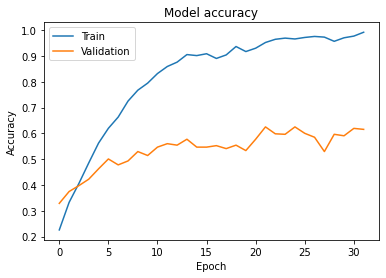

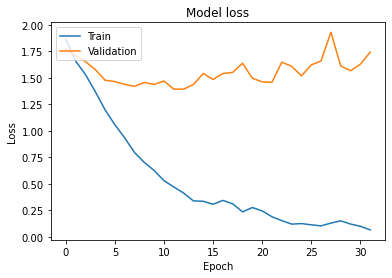

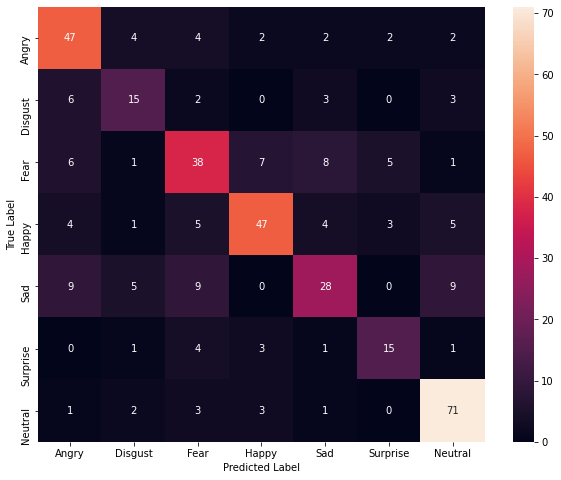

In [0]:
display_results(lstm_model, lstm_model_history)

## Bidirectional LSTM

In [0]:
def build_bd_lstm(hidden_nodes, optimizer, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input(X.shape[1:]))
        model.add(Bidirectional(LSTM(hidden_nodes, dropout=dropout)))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

def build_bd_lstm(hidden_nodes, optimizer, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input(X.shape[1:]))
        model.add(Bidirectional(LSTM(hidden_nodes, dropout=dropout, return_sequences=True)))
        model.add(Flatten())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
hidden_units_size = 200
optimizer = tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=1e-7)
cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]

bd_lstm_model = build_bd_lstm(hidden_units_size, optimizer)
bd_lstm_model_history = train(bd_lstm_model, batch_size=256, epochs=200, cb=cb)
tu.save_results(bd_lstm_model, bd_lstm_model_history, f'blstm-{hidden_units_size}')

Epoch 1/200
8/8 [==============================] - 3s 359ms/step - loss: 3.7626 - accuracy: 0.2682 - val_loss: 1.4773 - val_accuracy: 0.4368
Epoch 2/200
8/8 [==============================] - 4s 480ms/step - loss: 1.1462 - accuracy: 0.5594 - val_loss: 1.1813 - val_accuracy: 0.5632
Epoch 3/200
8/8 [==============================] - 4s 483ms/step - loss: 0.7911 - accuracy: 0.7130 - val_loss: 1.0187 - val_accuracy: 0.6383
Epoch 4/200
8/8 [==============================] - 4s 481ms/step - loss: 0.5445 - accuracy: 0.8047 - val_loss: 0.9493 - val_accuracy: 0.6739
Epoch 5/200
8/8 [==============================] - 5s 685ms/step - loss: 0.3882 - accuracy: 0.8589 - val_loss: 0.8910 - val_accuracy: 0.6976
Epoch 6/200
8/8 [==============================] - 4s 487ms/step - loss: 0.2901 - accuracy: 0.9010 - val_loss: 0.9059 - val_accuracy: 0.7016
Epoch 7/200
8/8 [==============================] - 4s 485ms/step - loss: 0.2477 - accuracy: 0.9151 - val_loss: 0.9310 - val_accuracy: 0.6996
Epoch 8/200
8

60/60 [==============================] - 3s 44ms/step - loss: 0.2248 - accuracy: 0.9672
Train dataset accuracy: 96.72%
16/16 [==============================] - 1s 47ms/step - loss: 1.7812 - accuracy: 0.6680
Validation dataset accuracy: 66.80%
1/1 [==============================] - 0s 1ms/step - loss: 1.9992 - accuracy: 0.6923
Test dataset accuracy: 69.23%


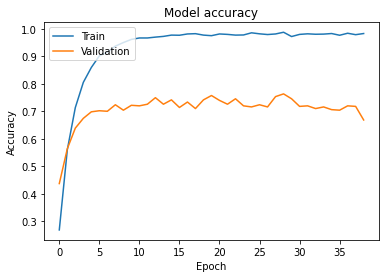

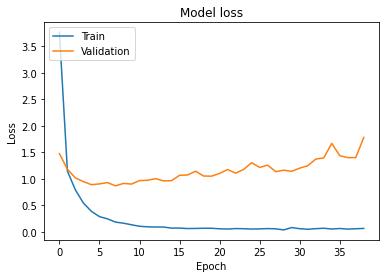

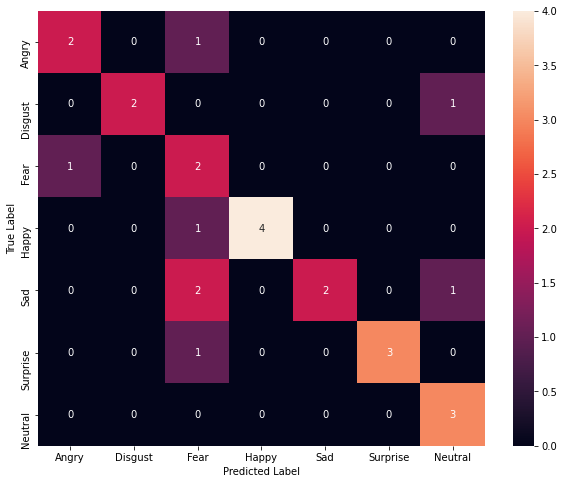

In [0]:
display_results(bd_lstm_model, bd_lstm_model_history)

## 2 layers of BLSTM

In [0]:
def build_blstm_2(hidden_nodes, optimizer, dropout=0.2):
    with strategy.scope():
        model = Sequential()
        model.add(Input(X.shape[1:]))
        model.add(Bidirectional(LSTM(hidden_nodes, dropout=dropout, return_sequences=True)))
        model.add(Bidirectional(LSTM(hidden_nodes, dropout=dropout)))
        model.add(Dense(7, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

In [0]:
hidden_units_size = 200
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]

blstm_2_model = build_blstm_2(hidden_units_size, optimizer)
blstm_2_model_history = train(blstm_2_model, batch_size=256, epochs=200, cb=cb)
tu.save_results(blstm_2_model, blstm_2_model_history, f'blstm2-{hidden_units_size}')

Epoch 1/200
6/6 [==============================] - 6s 969ms/step - loss: 1.7913 - accuracy: 0.2734 - val_loss: 1.7683 - val_accuracy: 0.3595
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 1.5357 - accuracy: 0.4062 - val_loss: 1.6490 - val_accuracy: 0.4283
Epoch 3/200
6/6 [==============================] - 6s 956ms/step - loss: 1.3103 - accuracy: 0.5046 - val_loss: 1.5295 - val_accuracy: 0.4723
Epoch 4/200
6/6 [==============================] - 5s 784ms/step - loss: 1.1189 - accuracy: 0.5807 - val_loss: 1.5290 - val_accuracy: 0.4971
Epoch 5/200
6/6 [==============================] - 6s 948ms/step - loss: 0.9560 - accuracy: 0.6387 - val_loss: 1.3579 - val_accuracy: 0.5698
Epoch 6/200
6/6 [==============================] - 6s 950ms/step - loss: 0.8068 - accuracy: 0.7051 - val_loss: 1.2849 - val_accuracy: 0.5813
Epoch 7/200
6/6 [==============================] - 6s 948ms/step - loss: 0.6557 - accuracy: 0.7819 - val_loss: 1.2227 - val_accuracy: 0.5985
Epoch 8/200
6/6 

48/48 [==============================] - 4s 88ms/step - loss: 0.0404 - accuracy: 0.9928
Train dataset accuracy: 99.28%
17/17 [==============================] - 1s 88ms/step - loss: 1.4248 - accuracy: 0.6730
Validation dataset accuracy: 67.30%
13/13 [==============================] - 1s 87ms/step - loss: 1.2597 - accuracy: 0.6870
Test dataset accuracy: 68.70%


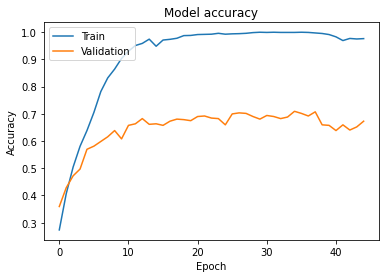

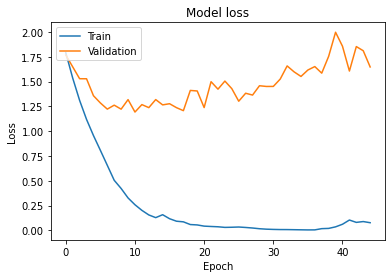

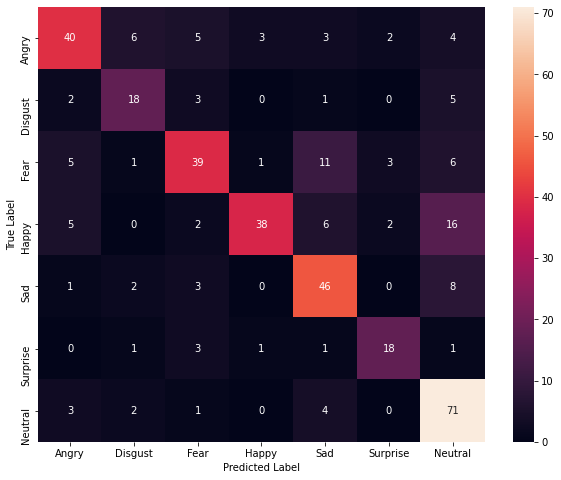

In [0]:
display_results(blstm_2_model, blstm_2_model_history)

# Test with random audio

In [0]:
from IPython.display import Audio
from emotenn import audio_utils as au

In [0]:
def show_mfcc(features):
    plt.imshow(features, aspect='auto')

In [0]:
audio = au.record_audio()
audio_path = '/content/tmp.wav'
with open(audio_path, 'wb') as f:
    f.write(audio.data)

audio

LSTM: Sad
Bidirectional LSTM: Neutral


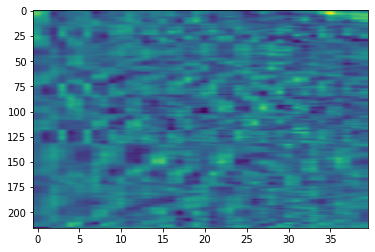

In [0]:
y, sample_rate = librosa.load(audio_path, res_type='kaiser_fast', duration=2.5, sr=44100)
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=40)
mfcc = normalize_mfcc(mfcc)

z = np.zeros((mfcc.shape[0], 216 - mfcc.shape[1]), dtype=mfcc.dtype)
mfcc = np.concatenate((mfcc,z), axis=1)
mfcc = np.swapaxes(mfcc, 0, 1)
mfcc = np.reshape(mfcc, (1, 216, 40))
show_mfcc(mfcc[0])

class_idx = lstm_model.predict_classes(mfcc)[0]
print('LSTM: ' + ct.CLASS_NAMES[class_idx])
class_idx = bd_lstm_model.predict_classes(mfcc)[0]
print('Bidirectional LSTM: ' + ct.CLASS_NAMES[class_idx])

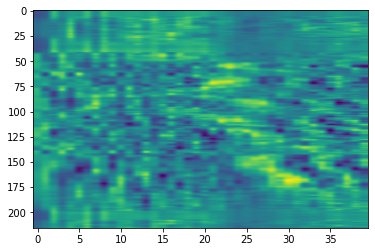

In [0]:
show_mfcc(X[1])